In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import numpy as np
from collections import namedtuple

#tf.debugging.set_log_device_placement(True)
print("TensorFlow Version:",tf.__version__)
print("Hub version: ", hub.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow Version: 2.2.0-rc2
Hub version:  0.8.0
Num GPUs Available:  1


In [2]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

MAX_SEQ_LEN = 64
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [3]:
'''
x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(6, activation="sigmoid", name="dense_output")(x)

model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)


model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
'''


'\nx = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)\nx = tf.keras.layers.Dropout(0.2)(x)\nout = tf.keras.layers.Dense(6, activation="sigmoid", name="dense_output")(x)\n\nmodel = tf.keras.models.Model(\n      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)\n\n\nmodel.compile(loss=\'binary_crossentropy\',\n                  optimizer=\'adam\',\n                  metrics=[\'accuracy\'])\n'

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [5]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file,do_lower_case)

In [6]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [7]:
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [8]:
def create_single_input(sentence, MAX_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]

    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

In [9]:
def create_input_array(sentences):

    input_ids, input_masks, input_segments = [], [], []

    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments = create_single_input(sentence,MAX_SEQ_LEN-2)
        
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)

    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [10]:
import pandas as pd

In [11]:
dataset = pd.read_csv('../dataset.csv', index_col=0)
display(dataset.loc['Content'])

Article 1     At least 1,200 people have been killed and mil...
Article 2                                                   NaN
Article 3     The city's gung-ho approach to development has...
Article 4     Hillary Clinton claimed Trump was “temperament...
Article 5     The Mawson study is a groundbreaking study of ...
Article 6     As we grow older we suffer a decline in mental...
Article 7                                                   NaN
Article 8     Preventing Alzheimer's naturally is as simple ...
Article 9     Some pharmaceutical medicines can cause you im...
Article 10    The bill would also mean insurers could consid...
Article 11    We physicians with all our training, knowledge...
Article 12    “We advise against the use of coconut oil," th...
Article 13    The FDA has published conclusive proof on thei...
Article 14    CONFIRMED: E-CIGARETTES CAUSE A HORRIBLE INCUR...
Article 15    Mom's warning is spreading like wildfire – sce...
Article 16    Every parents worries abou

In [12]:
article_content = dataset.loc['Content'].values

In [13]:
train_sentences = ['This is a nice sentence.', 'This is another sentence!', 'Hello Friends']

In [14]:
inputs = create_input_array(str(article_content))

100%|██████████| 11106/11106 [00:00<00:00, 98381.03it/s] 


In [90]:
print(inputs)

[array([[ 101, 1031,  102, ...,    0,    0,    0],
       [ 101, 1000,  102, ...,    0,    0,    0],
       [ 101, 1037,  102, ...,    0,    0,    0],
       ...,
       [ 101, 1041,  102, ...,    0,    0,    0],
       [ 101, 1005,  102, ...,    0,    0,    0],
       [ 101, 1033,  102, ...,    0,    0,    0]], dtype=int32), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)]


In [91]:
# generate embeddings
pool_embs, all_embs = model.predict(inputs)

In [99]:
print(np.shape(pool_embs))
print(np.shape(all_embs))

(11106, 768)
(11106, 64, 768)


In [96]:
all_embs1 = np.swapaxes(all_embs, 0, 1)

In [85]:
sum_all_embs = np.sum(all_embs, axis=0)
print(np.shape(sum_all_embs))

()


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [87]:
print(np.shape(all_embs))

(3,)


(64, 2)


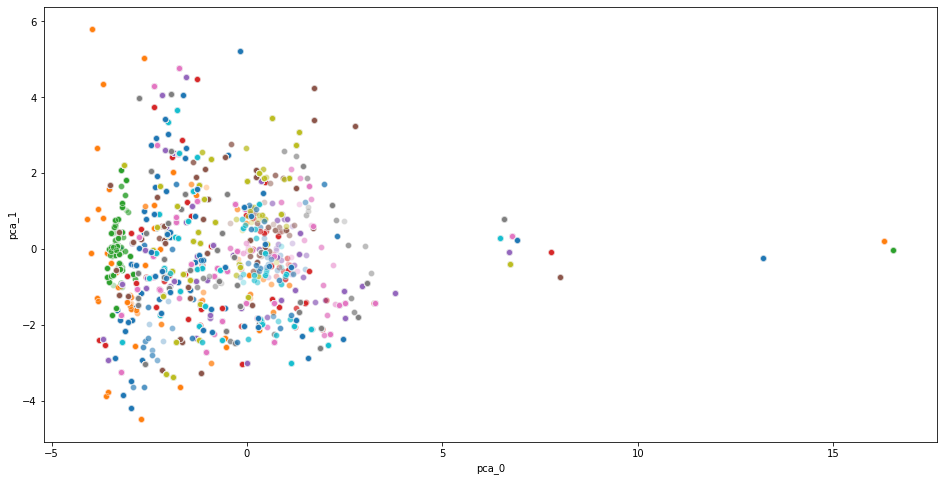

In [100]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(np.squeeze(all_embs[0]))
print(np.shape(pca_result))

#plt.figure()
#plt.plot(pca_result[:,0], pca_result[:,1], '*')

plt.figure(figsize=(16,8))
for idx, embedding in enumerate(all_embs1):
    if idx > 10:
        break
    pca_result = pca.fit_transform(np.squeeze(embedding))
    df = pd.DataFrame(pca_result, columns=['pca_0', 'pca_1'])
    
    '''
    plt.plot(df['pca_0'], df['pca_1'], '*')
    '''
    sns.scatterplot(
        x="pca_0", y="pca_1",
        #hue="y",
        #palette=sns.color_palette("hls", 10),
        data=df,
        legend="full",
        alpha=0.3
    )

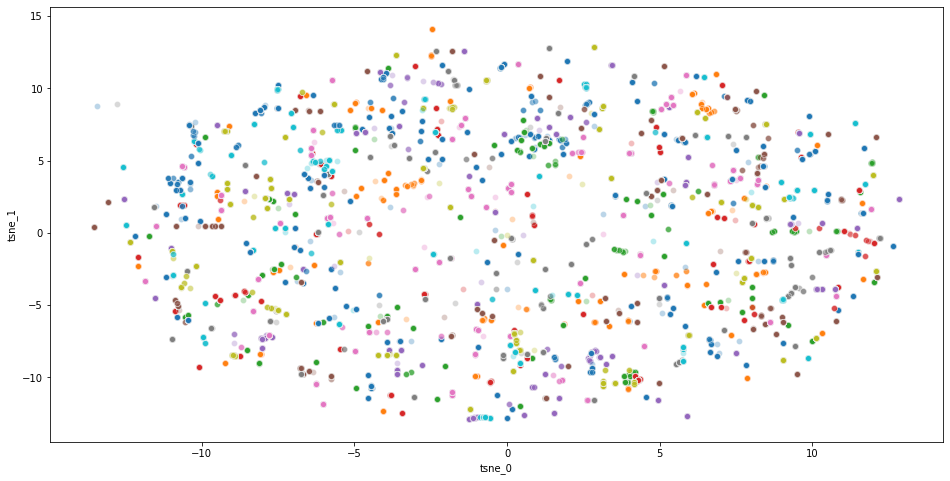

In [104]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.squeeze(all_embs[0]))
tsne_results.shape


#plt.figure()
#plt.plot(tsne_results[:,0], tsne_results[:,1], '*')

plt.figure(figsize=(16,8))
for idx, embedding in enumerate(all_embs1):
    if idx > 10:
        break
    tsne_results = tsne.fit_transform(np.squeeze(embedding))
    df_tsne = pd.DataFrame(tsne_results, columns=['tsne_0', 'tsne_1'])
    sns.scatterplot(
        x="tsne_0", y="tsne_1",
        #hue="y",
        #palette=sns.color_palette("hls", 10),
        data=df_tsne,
        legend="full",
        alpha=0.3
    )

In [22]:
#train_sentences = df["comment_text"].fillna("CVxTz").values
#list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
#train_y = df[list_classes].values

In [23]:
#model.fit(inputs, train_y, epochs=1, batch_size=32, validation_split=0.2, shuffle=True)